In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ============================================================================
# STRESS LEVEL CLASSIFICATION MODEL TRAINING
# Features: unlock_time_ms, avg_touch_pressure
# Target: stress_level (0 or 1)
# ============================================================================

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Import classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# For deep learning (optional)
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)




In [3]:
# ============================================================================
# 1. LOAD AND EXPLORE DATA
# ============================================================================

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/dataset/unlock_touch_stress_dataset.csv')

print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"\nTotal samples: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nStress Level Distribution:")
print(df['stress_level'].value_counts())
print(f"\nClass Balance: {df['stress_level'].value_counts(normalize=True) * 100}")



DATASET OVERVIEW

Total samples: 500

Columns: ['user_id', 'unlock_time_ms', 'avg_touch_pressure', 'stress_level']

Stress Level Distribution:
stress_level
0    276
1    224
Name: count, dtype: int64

Class Balance: stress_level
0    55.2
1    44.8
Name: proportion, dtype: float64


In [4]:
# ============================================================================
# 2. PREPARE DATA
# ============================================================================

# Select features and target
X = df[['unlock_time_ms', 'avg_touch_pressure']].values
y = df['stress_level'].values

print("\n" + "="*70)
print("DATA PREPARATION")
print("="*70)
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Feature scaling (important for many ML algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed using StandardScaler")
print(f"Training mean: {X_train_scaled.mean(axis=0)}")
print(f"Training std: {X_train_scaled.std(axis=0)}")




DATA PREPARATION

Feature matrix shape: (500, 2)
Target vector shape: (500,)

Training set size: 400 (80.0%)
Testing set size: 100 (20.0%)

Feature scaling completed using StandardScaler
Training mean: [2.00894856e-15 4.38538095e-17]
Training std: [1. 1.]



MODEL TRAINING

Training Logistic Regression...
  ✓ Train Accuracy: 0.5500
  ✓ Test Accuracy: 0.5800
  ✓ F1-Score: 0.1250

Training Decision Tree...
  ✓ Train Accuracy: 1.0000
  ✓ Test Accuracy: 0.4700
  ✓ F1-Score: 0.3614

Training Random Forest...
  ✓ Train Accuracy: 1.0000
  ✓ Test Accuracy: 0.4500
  ✓ F1-Score: 0.3373

Training Gradient Boosting...
  ✓ Train Accuracy: 0.8825
  ✓ Test Accuracy: 0.4700
  ✓ F1-Score: 0.3117

Training SVM (RBF)...
  ✓ Train Accuracy: 0.5900
  ✓ Test Accuracy: 0.5500
  ✓ F1-Score: 0.3077

Training K-Nearest Neighbors...
  ✓ Train Accuracy: 0.6825
  ✓ Test Accuracy: 0.4900
  ✓ F1-Score: 0.3544

Training Naive Bayes...
  ✓ Train Accuracy: 0.5550
  ✓ Test Accuracy: 0.5400
  ✓ F1-Score: 0.0000

MODEL COMPARISON

               Model  Train Accuracy  Test Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression          0.5500           0.58   1.000000 0.066667  0.125000 0.617374
          SVM (RBF)          0.5900           0.55   0.500000 0.222

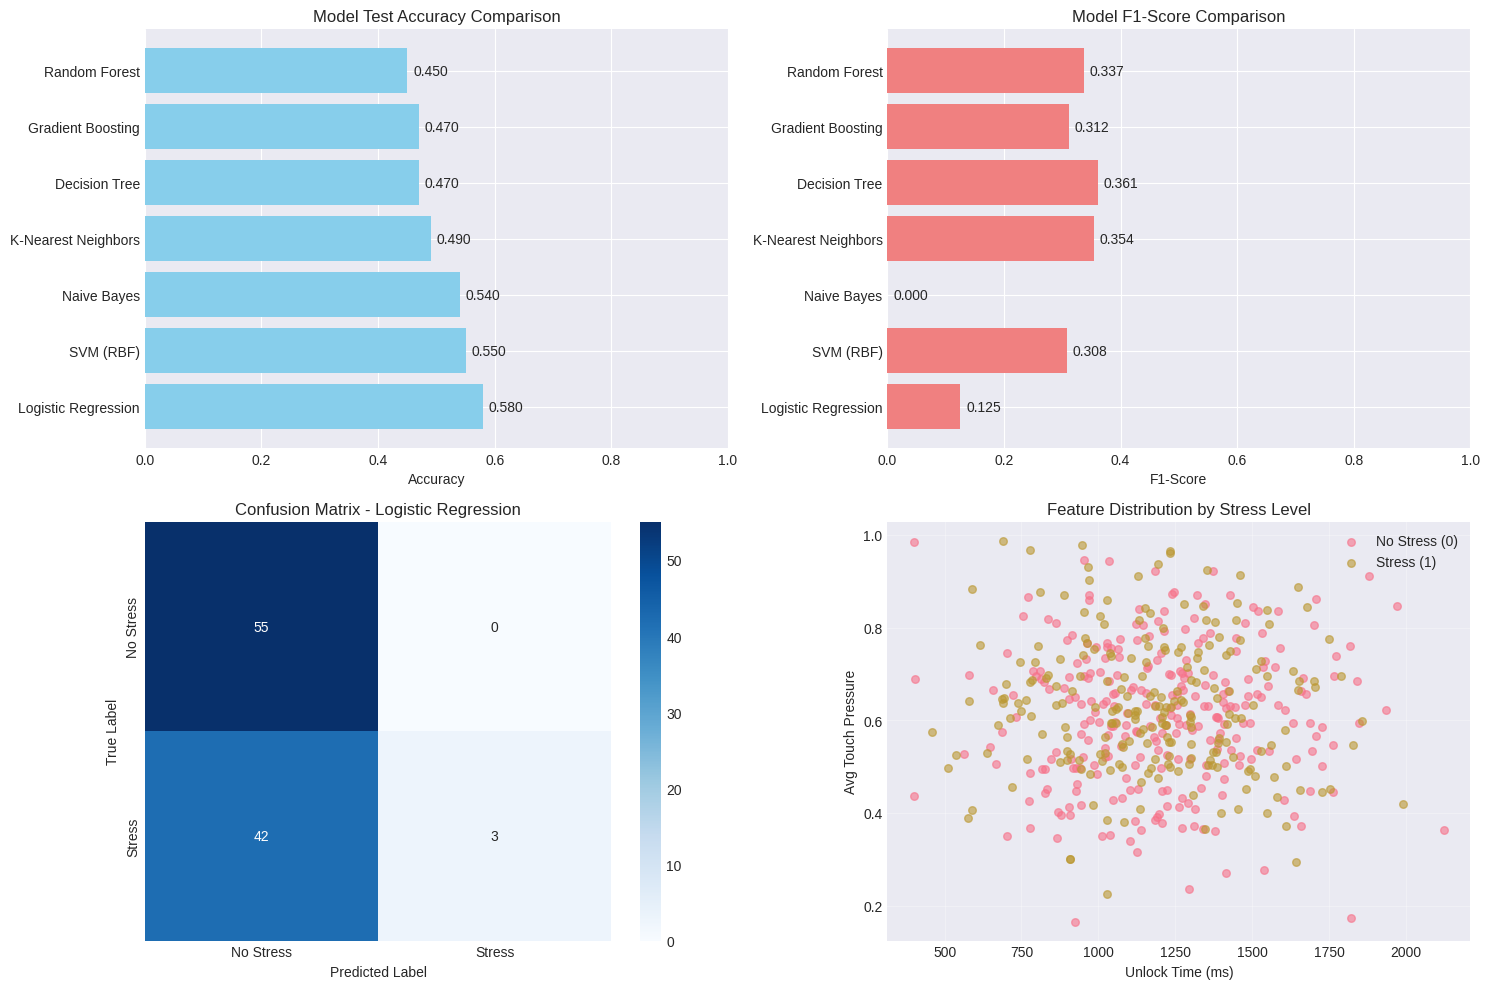

In [5]:
# ============================================================================
# 3. TRAIN MULTIPLE MODELS
# ============================================================================

print("\n" + "="*70)
print("MODEL TRAINING")
print("="*70)

# Define models to train
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

# Store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # Get probability predictions (for ROC-AUC)
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred_proba = y_pred_test

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    except:
        roc_auc = 0.0

    # Store results
    results[name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'predictions': y_pred_test
    }

    print(f"  ✓ Train Accuracy: {train_accuracy:.4f}")
    print(f"  ✓ Test Accuracy: {test_accuracy:.4f}")
    print(f"  ✓ F1-Score: {f1:.4f}")

# ============================================================================
# 4. COMPARE MODELS
# ============================================================================

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'Train Accuracy': [r['train_accuracy'] for r in results.values()],
    'Test Accuracy': [r['test_accuracy'] for r in results.values()],
    'Precision': [r['precision'] for r in results.values()],
    'Recall': [r['recall'] for r in results.values()],
    'F1-Score': [r['f1_score'] for r in results.values()],
    'ROC-AUC': [r['roc_auc'] for r in results.values()]
})

comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)
print("\n", comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test Accuracy: {results[best_model_name]['test_accuracy']:.4f}")
print(f"   F1-Score: {results[best_model_name]['f1_score']:.4f}")

# ============================================================================
# 5. DETAILED EVALUATION OF BEST MODEL
# ============================================================================

print("\n" + "="*70)
print(f"DETAILED EVALUATION - {best_model_name}")
print("="*70)

y_pred_best = results[best_model_name]['predictions']

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix:")
print(cm)
print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['No Stress (0)', 'Stress (1)']))

# ============================================================================
# 6. VISUALIZATIONS
# ============================================================================

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Figure 1: Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy comparison
axes[0, 0].barh(comparison_df['Model'], comparison_df['Test Accuracy'], color='skyblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Test Accuracy Comparison')
axes[0, 0].set_xlim([0, 1])
for i, v in enumerate(comparison_df['Test Accuracy']):
    axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# F1-Score comparison
axes[0, 1].barh(comparison_df['Model'], comparison_df['F1-Score'], color='lightcoral')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Model F1-Score Comparison')
axes[0, 1].set_xlim([0, 1])
for i, v in enumerate(comparison_df['F1-Score']):
    axes[0, 1].text(v + 0.01, i, f'{v:.3f}', va='center')

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'])
axes[1, 0].set_title(f'Confusion Matrix - {best_model_name}')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# Feature distribution by stress level
df_plot = df[['unlock_time_ms', 'avg_touch_pressure', 'stress_level']].copy()
axes[1, 1].scatter(df_plot[df_plot['stress_level']==0]['unlock_time_ms'],
                   df_plot[df_plot['stress_level']==0]['avg_touch_pressure'],
                   alpha=0.6, label='No Stress (0)', s=30)
axes[1, 1].scatter(df_plot[df_plot['stress_level']==1]['unlock_time_ms'],
                   df_plot[df_plot['stress_level']==1]['avg_touch_pressure'],
                   alpha=0.6, label='Stress (1)', s=30)
axes[1, 1].set_xlabel('Unlock Time (ms)')
axes[1, 1].set_ylabel('Avg Touch Pressure')
axes[1, 1].set_title('Feature Distribution by Stress Level')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
print("✓ Saved: model_evaluation.png")
plt.show()

# Figure 2: Feature Importance (for tree-based models)
if best_model_name in ['Decision Tree', 'Random Forest', 'Gradient Boosting']:
    plt.figure(figsize=(10, 6))
    feature_importance = best_model.feature_importances_
    features = ['unlock_time_ms', 'avg_touch_pressure']

    plt.barh(features, feature_importance, color=['#3498db', '#e74c3c'])
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlim([0, 1])
    for i, v in enumerate(feature_importance):
        plt.text(v + 0.01, i, f'{v:.3f}', va='center')

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: feature_importance.png")
    plt.show()







In [6]:
# ============================================================================
# 7. SAVE THE MODEL
# ============================================================================

import pickle

print("\n" + "="*70)
print("SAVING MODEL AND SCALER")
print("="*70)

# Save best model
with open('stress_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("✓ Saved: stress_model.pkl")

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Saved: scaler.pkl")

# Save model info
model_info = {
    'model_name': best_model_name,
    'test_accuracy': results[best_model_name]['test_accuracy'],
    'f1_score': results[best_model_name]['f1_score'],
    'features': ['unlock_time_ms', 'avg_touch_pressure'],
    'target': 'stress_level'
}

with open('model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("✓ Saved: model_info.pkl")


SAVING MODEL AND SCALER
✓ Saved: stress_model.pkl
✓ Saved: scaler.pkl
✓ Saved: model_info.pkl


In [7]:
# ============================================================================
# 8. PREDICTION FUNCTION
# ============================================================================

def predict_stress(unlock_time_ms, avg_touch_pressure):
    """
    Predict stress level for given inputs

    Args:
        unlock_time_ms: Time to unlock device in milliseconds
        avg_touch_pressure: Average touch pressure (0-1)

    Returns:
        prediction: 0 (No Stress) or 1 (Stress)
        probability: Probability of stress
    """
    # Prepare input
    input_data = np.array([[unlock_time_ms, avg_touch_pressure]])

    # Scale input
    input_scaled = scaler.transform(input_data)

    # Predict
    prediction = best_model.predict(input_scaled)[0]

    if hasattr(best_model, 'predict_proba'):
        probability = best_model.predict_proba(input_scaled)[0]
        stress_prob = probability[1]
    else:
        stress_prob = prediction

    return prediction, stress_prob

In [8]:
# ============================================================================
# 9. TEST PREDICTION FUNCTION
# ============================================================================

print("\n" + "="*70)
print("TESTING PREDICTION FUNCTION")
print("="*70)

# Test with some examples
test_cases = [
    (500, 0.9),   # Short unlock time, high pressure
    (1500, 0.5),  # Long unlock time, medium pressure
    (1200, 0.7),  # Medium unlock time, high pressure
]

print("\nSample Predictions:")
for unlock_time, pressure in test_cases:
    pred, prob = predict_stress(unlock_time, pressure)
    status = "STRESS" if pred == 1 else "NO STRESS"
    print(f"\nInput: unlock_time={unlock_time}ms, pressure={pressure:.2f}")
    print(f"  → Prediction: {status} ({pred})")
    print(f"  → Stress Probability: {prob:.2%}")

print("\n" + "="*70)
print("MODEL TRAINING COMPLETE!")
print("="*70)
print("\nFiles saved:")
print("  • stress_model.pkl - Trained model")
print("  • scaler.pkl - Feature scaler")
print("  • model_info.pkl - Model metadata")
print("  • model_evaluation.png - Evaluation charts")
if best_model_name in ['Decision Tree', 'Random Forest', 'Gradient Boosting']:
    print("  • feature_importance.png - Feature importance chart")


TESTING PREDICTION FUNCTION

Sample Predictions:

Input: unlock_time=500ms, pressure=0.90
  → Prediction: STRESS (1)
  → Stress Probability: 52.69%

Input: unlock_time=1500ms, pressure=0.50
  → Prediction: NO STRESS (0)
  → Stress Probability: 41.33%

Input: unlock_time=1200ms, pressure=0.70
  → Prediction: NO STRESS (0)
  → Stress Probability: 45.66%

MODEL TRAINING COMPLETE!

Files saved:
  • stress_model.pkl - Trained model
  • scaler.pkl - Feature scaler
  • model_info.pkl - Model metadata
  • model_evaluation.png - Evaluation charts
